
## Online/Offline 出し分けモデル

In [45]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm

In [46]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

In [47]:
# parameter
#val_start_date = '2020-09-16'
#val_start_date = '2020-09-09'
val_start_date = '2020-09-02'
#topk = 50
topk = 30
#ch = 'on'
ch = 'off'

In [48]:
from datetime import datetime, date, timedelta
val_end_date = pd.to_datetime(val_start_date) + timedelta(days=7)

In [49]:
val_end_date = str(val_end_date.strftime('%Y-%m-%d'))
print(val_start_date, val_end_date)

2020-09-02 2020-09-09


In [50]:
# データの読み込み
dir = 'h-and-m-personalized-fashion-recommendations/'
path = '../input/' + dir 

#customers = pd.read_csv(path + 'customers.csv')
#articles = pd.read_csv(path + 'articles.csv')
transactions_train = pd.read_csv(path + 'transactions_train.csv')

In [51]:
# save memory https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
# 64文字もあるが、末尾16文字だけでcustomerを一意にid可能
# 使われている文字は0-9, a-fなので16進数で変換してintで扱える
# 16進数 = 4bit, 4bit * 16 / 8 = 8 byte
# 64 byte -> 8 byteに削減, int64で表現可能
transactions_train['customer_id'] = transactions_train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
# メモリ削減
transactions_train['article_id'] = transactions_train['article_id'].astype('int32')

In [52]:
sub = pd.read_csv(path + 'sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [53]:
sub['customer_id'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [54]:
visualize_df(transactions_train)

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050831,2
1,2018-09-20,-6846340800584936,541518023,0.030492,2
2,2018-09-20,-8334631767138808638,505221004,0.015237,2
3,2018-09-20,-8334631767138808638,685687003,0.016932,2
4,2018-09-20,-8334631767138808638,685687004,0.016932,2


In [55]:
# 提出サンプルの確認
sub.head()

,customer_id
0,6883939031699146327
1,-7200416642310594310
2,-6846340800584936
3,-94071612138601410
4,-283965518499174310


### Divide data

In [56]:
# transactions_train['t_dat'].unique()[-7:]

# array(['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
#       '2020-09-20', '2020-09-21', '2020-09-22'], dtype=object)


In [57]:
train_data = transactions_train.query(f"'{val_start_date}' <= t_dat and t_dat < '{val_end_date}'").reset_index(drop=True)
feature_data = transactions_train.query(f"t_dat < '{val_end_date}'").reset_index(drop=True) # 期間かぶっててもよい
visualize_df(train_data)

(264657, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-02,-2004322025990877963,820671001,0.016932,1
1,2020-09-02,-6382781975245111187,882354001,0.015237,2
2,2020-09-02,-6382781975245111187,817354001,0.025407,2
3,2020-09-02,-6382781975245111187,817354001,0.025407,2
4,2020-09-02,-4203010420020643360,899002003,0.010153,1


### Online/Offlineに絞る

In [58]:
train_ch = feature_data.groupby('customer_id')['sales_channel_id'].agg('mean').reset_index(name='channel')

In [59]:
if ch == 'on':
    train_ch = train_ch.query('channel >= 1.5')
else:
    train_ch = train_ch.query('channel < 1.5')
train_ch = train_ch['customer_id']

In [60]:
train_data = pd.merge(train_data, train_ch, on='customer_id', how='inner')
train_data

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-02,-2004322025990877963,820671001,0.016932,1
1,2020-09-02,-6382781975245111187,882354001,0.015237,2
2,2020-09-02,-6382781975245111187,817354001,0.025407,2
3,2020-09-02,-6382781975245111187,817354001,0.025407,2
4,2020-09-06,-6382781975245111187,903473001,0.101678,1
...,...,...,...,...,...
69711,2020-09-08,4962548572027622207,923340001,0.015254,1
69712,2020-09-08,6922210607220550580,673677002,0.023661,1
69713,2020-09-08,6922210607220550580,868823008,0.023661,1
69714,2020-09-08,6922210607220550580,821746001,0.020492,1


### customer_data

In [61]:
customers = pd.read_csv(path + 'customers.csv')
customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [62]:
customers = customers[['customer_id','age']]
customers.head()

,customer_id,age
0,6883939031699146327,49.0
1,-7200416642310594310,25.0
2,-6846340800584936,24.0
3,-94071612138601410,54.0
4,-283965518499174310,52.0


In [63]:
customers.describe()

,customer_id,age
count,1.371980e+06,1.356119e+06
mean,-8.899354e+15,3.638696e+01
std,5.326640e+18,1.431363e+01
min,-9.223353e+18,1.600000e+01
25%,-4.624561e+18,2.400000e+01
50%,-1.147651e+16,3.200000e+01
75%,4.602000e+18,4.900000e+01
max,9.223371e+18,9.900000e+01


In [64]:
# 年齢がないものは0歳としておく (''だと後からintにcastできないため)
train_data = pd.merge(train_data, customers, on='customer_id', how='left').fillna('0')

In [65]:
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                  object
dtype: object

In [66]:
train_data['age'].value_counts()

21.0    3456
25.0    3290
23.0    3118
24.0    3034
22.0    2879
        ... 
85.0       9
80.0       7
91.0       5
88.0       3
83.0       2
Name: age, Length: 72, dtype: int64

In [67]:
train_data['age'] = train_data['age'].astype('int32')
train_data.dtypes

t_dat                object
customer_id           int64
article_id            int32
price               float64
sales_channel_id      int64
age                   int32
dtype: object

### 単純なランキングから上位50件を取ってくる

In [68]:
# -30, 30-40, 40-50, 50- old
# -30, 30-50, 50- new
train_sort_30 = train_data.query('age < 30').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_50 = train_data.query('30 <= age and age < 50').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)
train_sort_60 = train_data.query('50 <= age').groupby('article_id', as_index=False).count().sort_values('customer_id', ascending=False)

In [69]:
#popular_list = train_sort.head(100)['article_id'].tolist()

In [70]:
#popular_list_under40 = train_sort_under40.head(100)['article_id'].tolist()
#popular_list_over40 = train_sort_over40.head(100)['article_id'].tolist()

In [71]:
popular_list_30 = train_sort_30.head(topk)['article_id'].tolist()
popular_list_50 = train_sort_50.head(topk)['article_id'].tolist()
popular_list_60 = train_sort_60.head(topk)['article_id'].tolist()

### Visualize

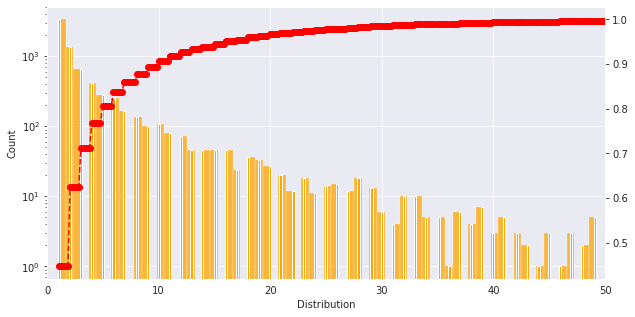

In [72]:
# 30
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_30, x='customer_id', bins=200, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_30, x='customer_id', bins=700, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

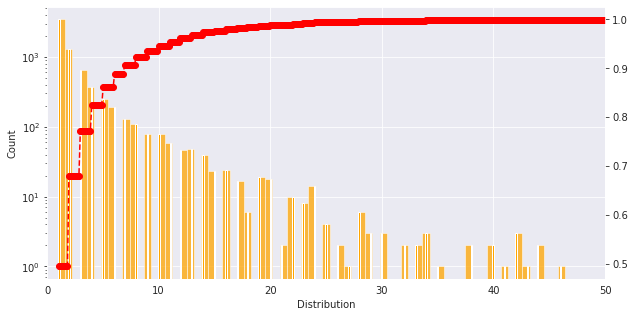

In [73]:
# 30 - 50

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_50, x='customer_id', bins=100, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_50, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

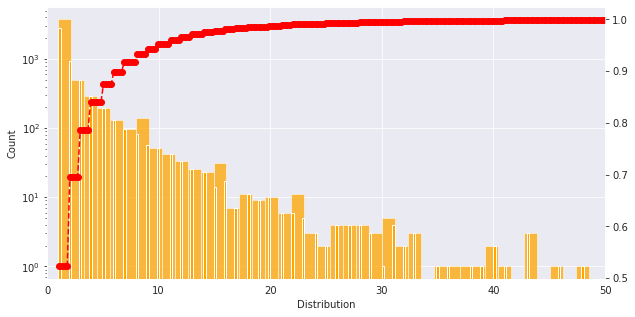

In [74]:
# 50 - 

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=train_sort_60, x='customer_id', bins=100, color='orange')
ax.set_xlabel('Distribution')
plt.yscale('log')
plt.xlim(0, 50)


# ヒストグラムプロットとビン情報の取得
#n, bins, patches = ax.hist(dt, alpha=0.7, label='Frequency')
n, bins, patches = ax.hist(data=train_sort_60, x='customer_id', bins=500, color='orange')

# 第2軸用値の算出
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
# 第2軸のプロット
ax2 = ax.twinx()
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
         label='Cumulative ratio')
ax2.grid(visible=False)

plt.show()

### Popular list

In [75]:
cnt=0
for i in popular_list_30:
    if i in popular_list_60:
        cnt+= 1
print('ratio=', cnt/100)

cnt=0
for i in popular_list_30[:30]:
    if i in popular_list_60[:30]:
        cnt+= 1
print('ratio 50=', cnt/30)

ratio= 0.07
ratio 50= 0.23333333333333334


In [76]:
popular_str_30 = [str(i) for i in popular_list_30]
popular_str_50 = [str(i) for i in popular_list_50]
popular_str_60 = [str(i) for i in popular_list_60]

In [77]:
join_popular_30 = ' '.join(popular_str_30)
join_popular_50 = ' '.join(popular_str_50)
join_popular_60 = ' '.join(popular_str_60)

In [78]:
join_popular_30

'916468001 915526001 372860001 918292001 714790020 916468002 762846031 915526002 751471001 372860002 456163060 821395005 918292004 673677002 156231001 568601006 892309001 456163086 850917001 898694001 863595006 914441003 898713001 706016001 929165002 898692003 800691008 556539001 896152001 685814003'

In [79]:
# subにcustomerをjoin
sub2 =  pd.merge(sub, customers, on='customer_id', how='left').fillna('0')
sub2['age'] = sub2['age'].astype('int32')

In [80]:
sub2

,customer_id,age
0,6883939031699146327,49
1,-7200416642310594310,25
2,-6846340800584936,24
3,-94071612138601410,54
4,-283965518499174310,52
...,...,...
1371975,7551062398649767985,24
1371976,-9141402131989464905,21
1371977,-8286316756823862684,21
1371978,2551401172826382186,18


In [81]:
sub2_30 = sub2.query('age < 30')
sub2_50 = sub2.query('30 <= age and age < 50')
sub2_60 = sub2.query('50 <= age')

In [82]:
sub2_30['prediction'] = join_popular_30
sub2_50['prediction'] = join_popular_50
sub2_60['prediction'] = join_popular_60

<ipython-input-82-002de98a161a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2_30['prediction'] = join_popular_30
<ipython-input-82-002de98a161a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2_50['prediction'] = join_popular_50
<ipython-input-82-002de98a161a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [83]:
sub = sub2_30.append(sub2_50, ignore_index=True)
sub = sub.append(sub2_60, ignore_index=True)

<ipython-input-83-7c0d680150d9>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub2_30.append(sub2_50, ignore_index=True)
<ipython-input-83-7c0d680150d9>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(sub2_60, ignore_index=True)


In [84]:
sub

,customer_id,age,prediction
0,-7200416642310594310,25,916468001 915526001 372860001 918292001 714790...
1,-6846340800584936,24,916468001 915526001 372860001 918292001 714790...
2,-2477030216582433370,0,916468001 915526001 372860001 918292001 714790...
3,-3402710142238164438,20,916468001 915526001 372860001 918292001 714790...
4,5669685583838440396,20,916468001 915526001 372860001 918292001 714790...
...,...,...,...
1371975,8959640756044895752,55,751471043 762846031 884319003 896152002 865929...
1371976,8536186189414498976,53,751471043 762846031 884319003 896152002 865929...
1371977,-1244504865876165278,51,751471043 762846031 884319003 896152002 865929...
1371978,5823894334162843119,52,751471043 762846031 884319003 896152002 865929...


### Submit

In [85]:
print(sub.shape)

(1371980, 3)


In [86]:
sub = sub.drop(columns='age')
sub

,customer_id,prediction
0,-7200416642310594310,916468001 915526001 372860001 918292001 714790...
1,-6846340800584936,916468001 915526001 372860001 918292001 714790...
2,-2477030216582433370,916468001 915526001 372860001 918292001 714790...
3,-3402710142238164438,916468001 915526001 372860001 918292001 714790...
4,5669685583838440396,916468001 915526001 372860001 918292001 714790...
...,...,...
1371975,8959640756044895752,751471043 762846031 884319003 896152002 865929...
1371976,8536186189414498976,751471043 762846031 884319003 896152002 865929...
1371977,-1244504865876165278,751471043 762846031 884319003 896152002 865929...
1371978,5823894334162843119,751471043 762846031 884319003 896152002 865929...


In [87]:
# backfill用のcsv書き出し、上位50件、直近1週間
sub.to_csv(f'{ch}_ranking_{val_start_date}_{topk}.csv', index=False)